In [1]:
%matplotlib inline
from decimal import Decimal
import itertools
from pprint import pprint

import common

from matplotlib import pyplot as plt
import matplotlib

In [2]:
import pandas
life = pandas.read_csv('2004-period-life-table.csv')

def lookup(start_age, current_age, key):
    r0 = life.iloc[start_age][key]
    r1 = life.iloc[current_age][key]
    
    r0 = Decimal(r0.replace(',', ''))
    r1 = Decimal(r1.replace(',', ''))
    return (r0, r1)
    

def male_mortality(current_age, start_age=65):
    (r0, r1) = lookup(start_age, current_age, 'Male Number of Lives')
    return r1 / r0

def female_mortality(current_age, start_age=65):
    (r0, r1) = lookup(start_age, current_age, 'Female Number of Lives')
    return r1 / r0

def both_alive(m_age, f_age):
    return male_mortality(m_age) * female_mortality(f_age)
def male_only_alive(m_age, f_age):
    return male_mortality(m_age) * (1 - female_mortality(f_age))
def female_only_alive(m_age, f_age):
    return female_mortality(f_age) * (1 - male_mortality(m_age))
def either_alive(m_age, f_age):
    neither = (1 - male_mortality(m_age)) * (1 - female_mortality(f_age))
    return 1 - neither

In [3]:
import random
import numpy

def die(i):
    if random.random() < either_alive(i, i):
        return die(i+1)
    else:
        # they didn't live to i, so their final
        # age was i-1
        return i - 1

def gen_age():
    return die(65)

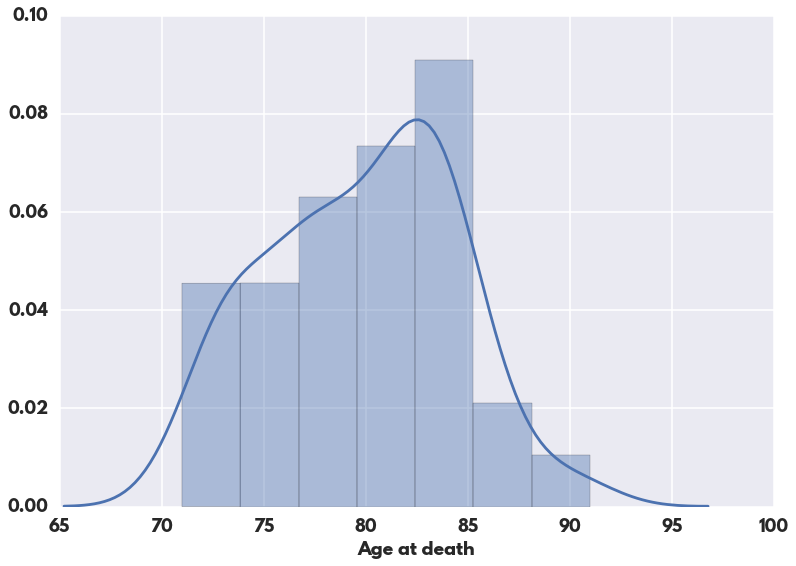

In [4]:
def chart_distribution(size=1000):
    import seaborn
    import pandas
    ages = []
    for _ in range(size):
        ages.append(gen_age())
    ages = pandas.Series(ages, name='Age at death')
    seaborn.distplot(ages)
chart_distribution(size=100)

In [5]:
from common import vpw_rates, ssr, cew, wer, hreff

def vpw_wer(us):
    lifespan = gen_age() - 65
        
    portfolio = starting_portfolio = Decimal('100')
    withdrawals = [vpw_rates[0]]
    portfolio -= vpw_rates[0] * portfolio
    
    returns = []

    for i in range(lifespan):
        r = us.random_year()
        gain = (r.stocks / 5 * 3) + (r.bonds / 5 * 2)
        returns.append(gain)

        portfolio *= (1 + gain)

        wd = vpw_rates[i+1] * portfolio
        withdrawals.append(wd / starting_portfolio)
        portfolio -= wd

    pprint(withdrawals)
    return wer(withdrawals, returns)

def em_wer(us):
    lifespan = gen_age() - 65
    
    portfolio = starting_portfolio = Decimal('100')
    withdrawals = []
    returns = []
    
    em = common.EM.calc_withdrawal(portfolio, 40)
    wd = em.send(None)
    withdrawals.append(wd / portfolio)
    portfolio -= wd
    
    for i in range(lifespan):
        r = us.random_year()
        gain = (r.stocks / 5 * 3) + (r.bonds / 5 * 2)
        returns.append(gain)
        
        portfolio *= (1 + gain)
    
        wd = em.send((portfolio, r.inflation))
        withdrawals.append(wd / starting_portfolio)
        portfolio -= wd

    print(cew(withdrawals))
    print(ssr(returns))
    return wer(withdrawals, returns)

def const_pct_wer(us, constant=Decimal('.055')):
    lifespan = gen_age() - 65
    
    portfolio = starting_portfolio = Decimal('100')
    returns = []
    withdrawals = []
    
    c = True
    while c:
        # start of year withdraw stuff
        wd = constant * portfolio
        portfolio -= wd
        withdrawals.append(wd / starting_portfolio)

        # end of year, receive gains
        r = us.random_year()
        gain = (r.stocks / 5 * 3) + (r.bonds / 5 * 2)
        portfolio *= (1 + gain)
        returns.append(gain)
        
        c = (lifespan > 0)
        lifespan -= 1

#    pprint(withdrawals)
#    pprint(returns)
#    print(cew(withdrawals))
#    print(ssr(returns))
    return wer(withdrawals, returns)

def calc_wer(n, fn_wer, returns=common.Returns_US_1871()):
    w = []
    for i in range(n):
        w.append(fn_wer(returns))
    return numpy.average([float(n) for n in w])

class FakeReturns:
    year = 0
    returns = [0.1, 0.1, -.1, -.1, .1]

    def random_year(self):
        r = self.returns[self.year]
        self.year += 1
        return common.AnnualChange(year=self.year, stocks=Decimal(r), bonds=Decimal(r), inflation=Decimal(0))

class LogNormalReturns:
    def __init__(self, mean, sigma):
        self.mean = mean
        self.sigma = sigma

    def random_year(self):
        r = numpy.random.lognormal(self.mean, self.sigma) - 1
        r = Decimal(r)
        return common.AnnualChange(year=0, stocks=r, bonds=r, inflation=Decimal(0))

# Numbers come from Blanchett et al. (2012)
# Index is the percentage of equities
historical = {
    0:  LogNormalReturns(.0231, .0483),
    10: LogNormalReturns(.0289, .0494),
    20: LogNormalReturns(.0342, .0572),
    30: LogNormalReturns(.0392, .0696),
    40: LogNormalReturns(.0438, .0845),
    50: LogNormalReturns(.0481, .1009),
    60: LogNormalReturns(.0520, .1182),
    70: LogNormalReturns(.0555, .1360),
    80: LogNormalReturns(.0586, .1542),
    90: LogNormalReturns(.0614, .1727),
    100:LogNormalReturns(.0638, .1915)
}
# From the paper..."For conservative forecasting purposes,
# the portfolio return was reduced by 50 bps and standard
# deviations were increased by 200 bps
conservative = {
    0:  LogNormalReturns(.0181, .0683),
    10: LogNormalReturns(.0239, .0694),
    20: LogNormalReturns(.0292, .0772),
    30: LogNormalReturns(.0342, .0896),
    40: LogNormalReturns(.0388, .1045),
    50: LogNormalReturns(.0431, .1209),
    60: LogNormalReturns(.0470, .1382),
    70: LogNormalReturns(.0505, .1560),
    80: LogNormalReturns(.0536, .1742),
    90: LogNormalReturns(.0564, .1927),
    100:LogNormalReturns(.0588, .2115)
}


#pprint(vpw_wer(FakeReturns()))
#pprint(const_pct_wer(FakeReturns()))
#pprint(em_wer(FakeReturns()))
#print(calc_wer(5000, vpw_wer))
print(calc_wer(1000, const_pct_wer, returns=conservative[40]))
#print(calc_wer(5000, em_wer))

0.538244648469


In [6]:
returns = [Decimal('0.1'), Decimal('0.1'), Decimal('-.1'), Decimal('-.1'), Decimal('.1')]
ssr(returns)

Decimal('0.213944249')

In [7]:
import math
from common import simulate_withdrawals, plot_two

def compare_em_vs_vpw(series, years=40, title=''):
    (r1, r2) = itertools.tee(series)
    x = simulate_withdrawals(r1, years=years)
    y = simulate_withdrawals(r2, years=years, withdraw=common.VPW)

    s1 = [n.withdraw_r for n in x]
    s2 = [n.withdraw_r for n in y]
    
    ceiling = max(max(s1), max(s2))
    if ceiling < 100000:
        ceiling = int(math.ceil(ceiling / 10000) * 10000)
    else:
        ceiling = int(math.ceil(ceiling / 100000) * 100000)
    
    plot_two(s1, s2, s1_title='EM', s2_title='VPW',
                       y_lim=[0,ceiling],
                       x_label='Year of Retirement', title=title)

def em_vs_vpw(year, years=40):
    compare_em_vs_vpw(common.Returns_US_1871().iter_from(year), title='%d: EM vs VPW' % year, years=years)

em_vs_vpw(1973, years=10)

NameError: name 'get_extended_mufp' is not defined

In [ ]:
data_series = common.Returns_US_1871()

income_diff = []

YEARS = 10
for i in range(data_series.years_of_data):
    year = i + 1871

    (s1, s2) = itertools.tee(data_series.iter_from(year))
    x = common.simulate_withdrawals(s1, years=YEARS)
    y = common.simulate_withdrawals(s2, years=YEARS, withdraw=common.VPW)

    # skip incomplete retirements
    if len(x) < YEARS:
        continue

    em_income = sum([n.withdraw_r for n in x])
    vpw_income = sum([n.withdraw_r for n in y])
    income_diff.append((em_income - vpw_income, year))

x_values = range(1871, 1871 + len(income_diff))

#ylim = [-100000, 50000]

#pprint(sorted(income_diff))

fig, ax1 = plt.subplots()
common.format_axis_labels_with_commas(ax1.get_yaxis())
ax1.plot(x_values, income_diff, 'b')
#ax1.set_ylim(ylim)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylabel('Income diff', color='b')
ax1.set_xlabel('Year of Retirement')

#ax2 = ax1.twinx()
#common.format_axis_labels_with_commas(ax2.get_yaxis())
#ax2.plot(x_values, portfolio_diff, 'g')
#ax2.set_ylim(ylim)
#for tl in ax2.get_yticklabels():
#    tl.set_color('g')
#ax2.set_ylabel('Portfolio diff', color='g')

plt.title('Cumulative income after %d year: EM vs. VPW' % YEARS)

plt.show()

In [ ]:
data_series = common.Returns_US_1871()

tpv_diff = []
YEARS = 40
for i in range(data_series.years_of_data):
    year = i + 1871

    (s1, s2) = itertools.tee(data_series.iter_from(year))
    x = common.simulate_withdrawals(s1, years=YEARS)
    y = common.simulate_withdrawals(s2, years=YEARS, withdraw=common.VPW)

    # skip incomplete retirements
    if len(x) < 40:
        continue

    tpv_diff.append(x[20].portfolio_r - y[20].portfolio_r)

x_values = range(1871, 1871 + len(tpv_diff))

fig, ax1 = plt.subplots()
common.format_axis_labels_with_commas(ax1.get_yaxis())
ax1.plot(x_values, tpv_diff, 'b')
#ax1.set_ylim(ylim)
for tl in ax1.get_yticklabels():
    tl.set_color('b')
ax1.set_ylabel('TPV Difference', color='b')
ax1.set_xlabel('Year of Retirement')

#ax2 = ax1.twinx()
#common.format_axis_labels_with_commas(ax2.get_yaxis())
#ax2.plot(x_values, portfolio_diff, 'g')
#ax2.set_ylim(ylim)
#for tl in ax2.get_yticklabels():
#    tl.set_color('g')
#ax2.set_ylabel('Portfolio diff', color='g')

plt.title('TPV Comparison: EM vs. VPW')

plt.show()